# Final Notebook

## Overview

Pneumonia is a very serious illness that can lead to dire health outcomes including death. Proper diagnosis is the first step in the process of successful treatment. Pneumonia is most often diagnosed by expert evaluation of a chest x-ray. In some healthcare settings, the number of potential pneumonia cases outpaces the capacity of trained personnel. We have built a model as a first evaluator, which provides an overworked healthcare worker with fewer x-rays to evaluate without having to worry about not catching a pneumonia case.

## Business Problem

Pneumonia is a leading cause of death among children under five, so it is of vital importance to healthcare systems and their patients that pneumonia is quickly and accurately diagnosed. In some settings there are more possible cases than there is time to evaluate them. For these clinics and hospitals, it would be very valuable to reduce that human workload, if that could be done without missing true cases of childhood pneumonia. If the first look could be automated, that would allow the experts an opportunity to direct their expertise towards other pressing medical concerns.

We developed a model that takes in an x-ray of child's lungs and predicts whether they have pneumonia. A false positive would be saying they do when they don't. A false negative would mean saying a child does not have pneumonia when they actually do. In this setting, a false positive is quite tolerable while a false negative is close to intolerable. False positives mean the healthcare worker has to examine a few extra x-rays. Considering the alternative is looking at ALL of the x-rays, this is absolutely acceptable. A false negative means a child does not receive appropriate treatment for a serious disease, which is a much bigger issue. Our model prioritizes recall above all else.

We did not optimize for recall exclusively however, because that would be essentially the system as it currently exists. Assume everyone has pneumonia and check for where you're wrong. Instead, we designed a model that sought to optimize for both recall and accuracy, and then selected the model with the highest recall score.

As the x-rays were going to be further examined by a medical professional, our model did not need to be easily interpretable. In any marginal cases the final call would be made by a doctor or other expert, so a black box model was not an issue, especially if such a model increased recall scores. Additionally, images are not suited to transparent models anyway, so a somewhat mysterious model is unavoidable.

## Data Understanding

Our data set is a collection of x-rays of children's lungs found at https://data.mendeley.com/datasets/rscbjbr9sj/3. Several different data sets are available at that link. We focused exclusively on the chest x-rays. As chest x-ray is the primary method of diagnosing pneumonia, these images are obviously relevant to our question. The target variable for our analysis is "pneumonia" vs. "normal." The images are already sorted into training, testing, and validation sets. The validation set was insufficiently sized for our purposes so we ignored it, instead creating a validation set within the training set.

## Data Preparation

Image data does not require the type of cleaning that numerical or language data does. The primary thing we had to do was scale down the images to ensure our computers could effectively work with the information. We opted to scale the large scans down to 64 x 64 pixels, which allowed us to try many models in a reasonable amount of time. After landing on our better models, we then ran them with larger versions of the image to see how much upping the resolution improved the outcomes. Our better models performed extremely well even at the lowest resolution.

## Modeling

As a baseline, we designed a simple convolutional neural network with a single convolutional layer. This model had a recall score of XX and an overall accuracy of XX.

We then began iterating to see what adjustments improved both scores, but especially recall. We experimented with adding convolutional layers, adjusting the learning rate both up and down, adding image augmentation to our training data, regularizing with a dropout layer, and various combinations of these adjustments. Several models scored quite highly on both recall and accuracy. Our final model, with a high accuracy and the highest recall score of all our attempts, was a convolutional neural network with multiple layers and the standard learning rate, along with no image augmentation or dropout regularization. At 64 x 64 image resolution, this model scored 99.4 for recall and 98.0 for accuracy on our validation set. At a higher resolution it scored XX for recall and XX for accuracy.

In addition to having an excellent recall score, this model is also useful because it works well even at low resolution. Higher resolution yields superior results, but this model could be used in a setting with limited computational power.

## Imports

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

## Plotting Function

The following function will plot the the recall and accuracy score for the training and validation sets of each model as it evolves from epoch to epoch. We chose the recall score because we are trying to minimize the presence of false negatives. A false negative diagnosis when a patient actually has pneumonia is the worst case scenario. 

In [42]:
def plot_loss_and_accuracy(results, final=False):
    
    if final:
        val_label="test"
    else:
        val_label="validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_precision = results.history['recall']
    val_precision = results.history['val_recall']
    train_accuracy = results.history['binary_accuracy']
    val_accuracy = results.history['val_binary_accuracy']

    # Setting up plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    # Plotting loss info
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label)
    ax1.legend()

    #Plotting recall
    ax2.set_title("Recall")
    sns.lineplot(x=results.epoch, y=train_precision, ax=ax2, label="train")
    sns.lineplot(x=results.epoch, y=val_precision, ax=ax2, label=val_label)
    ax2.legend()
    
    # Plotting accuracy info
    ax3.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax3, label="train")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax3, label=val_label)
    ax3.legend()

## Image Data Generator

Using ImageDataGenerator, we split our training folder in '../data/localdata/chest_xray/train' to a validation and training set for our model to train on. We also rescaled our image matrix components to values between 0 and 1. Since our images from our raw dataset have varying resolutions, we squished them to 300x300 for consistency and to lower r

In [33]:
# Directory path
train_data_dir = '../data/localdata/chest_xray/train'
test_data_dir = '../data/localdata/chest_xray/test'

# Get all the data in the directory data/localdata/chest_xray/test (624 images), and reshape them
training_generator = ImageDataGenerator(rescale=1/255, validation_split=0.25)

test_generator = ImageDataGenerator(rescale=1/255)

train_set = training_generator.flow_from_directory(
        train_data_dir, target_size=(300, 300), batch_size=32, color_mode='grayscale', 
        class_mode='binary', seed=42, subset='training')

val_set = training_generator.flow_from_directory(
    train_data_dir, target_size=(300, 300), batch_size=32, color_mode='grayscale', 
         class_mode='binary', seed=42, subset='validation')

test_set = test_generator.flow_from_directory(
        test_data_dir, target_size=(300, 300), batch_size=32, color_mode='grayscale', class_mode='binary')

# Create the datasets
train_images, train_labels = next(train_set)
test_images, test_labels = next(test_set)

Found 3918 images belonging to 2 classes.
Found 1304 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Image Data Generator with Data Augmentation

We ran several models with some data augmentation involved but we found that they performed overall poorer over the data set without augmentation. We applied four augmentations -- rotation_range=30, width_shift_range=0.3, height_shift_range=0.3, horizontal_flip=True. We did not use the following cell for data augmentation.

In [31]:
def Image_Data_Generator_Augmented():
    # Directory path
    train_data_dir = '../data/localdata/chest_xray/train'
    test_data_dir = '../data/localdata/chest_xray/test'
    
    # Get all the data in the directory data/localdata/chest_xray/test (624 images), and reshape them
    training_generator = ImageDataGenerator(rescale=1/255, validation_split=0.25,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True)
    test_generator = ImageDataGenerator(rescale=1/255)
    
    train_set = training_generator.flow_from_directory(
            train_data_dir, target_size=(300, 300), batch_size=32, color_mode='grayscale', 
            class_mode='binary', seed=42, subset='training')
    
    val_set = training_generator.flow_from_directory(
        train_data_dir, target_size=(300, 300), batch_size=32, color_mode='grayscale', 
             class_mode='binary', seed=42, subset='validation')
    
    test_set = test_generator.flow_from_directory(
            test_data_dir, target_size=(300, 300), batch_size=32, color_mode='grayscale', class_mode='binary')
    
    # Create the datasets
    train_images, train_labels = next(train_set)
    test_images, test_labels = next(test_set)

## Simple Model (Baseline)

Our first iteration of the model, or the baseline, was a neural network with only one input layer and one activation layer, the sigmoid. The flatten layer is required in order to make the transition from convolutional layers to activation function when dealing with image data. This model returns very high scores but is overfit since the training scores are 1. For our best model, we use a similar model but simply add one pooling layer and some regularization to help generalize the model.

In [5]:
simple_model = models.Sequential()
simple_model.add(layers.Conv2D(filters=32,
                       kernel_size=(3, 3),
                       activation='relu',
                       input_shape=(300, 300, 1)))
simple_model.add(layers.Flatten())
simple_model.add(layers.Dense(1, activation='sigmoid'))

simple_model.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=['Recall', 'BinaryAccuracy'])
                 
simple_results = simple_model.fit(train_set, epochs=10, validation_data=val_set)

Metal device set to: Apple M1
Epoch 1/10


2023-09-14 17:00:21.213258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-14 17:00:21.213349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-14 17:00:21.372871: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-14 17:00:21.545958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - ETA: 0s - loss: 0.7821 - recall: 0.9587 - binary_accuracy: 0.9194

2023-09-14 17:01:14.477528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - 60s 298ms/step - loss: 0.7821 - recall: 0.9587 - binary_accuracy: 0.9194 - val_loss: 0.0656 - val_recall: 0.9841 - val_binary_accuracy: 0.9794
Epoch 2/10
197/197 [==============================] - 55s 280ms/step - loss: 0.0380 - recall: 0.9943 - binary_accuracy: 0.9866 - val_loss: 0.0622 - val_recall: 0.9829 - val_binary_accuracy: 0.9775
Epoch 3/10
197/197 [==============================] - 53s 266ms/step - loss: 0.0088 - recall: 0.9996 - binary_accuracy: 0.9994 - val_loss: 0.0519 - val_recall: 0.9886 - val_binary_accuracy: 0.9818
Epoch 4/10
197/197 [==============================] - 52s 265ms/step - loss: 0.0025 - recall: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0548 - val_recall: 0.9898 - val_binary_accuracy: 0.9823
Epoch 5/10
197/197 [==============================] - 53s 266ms/step - loss: 9.4445e-04 - recall: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0608 - val_recall: 0.9863 - val_binary_accuracy: 0.9823
Epoch 6/10
197/197 [==

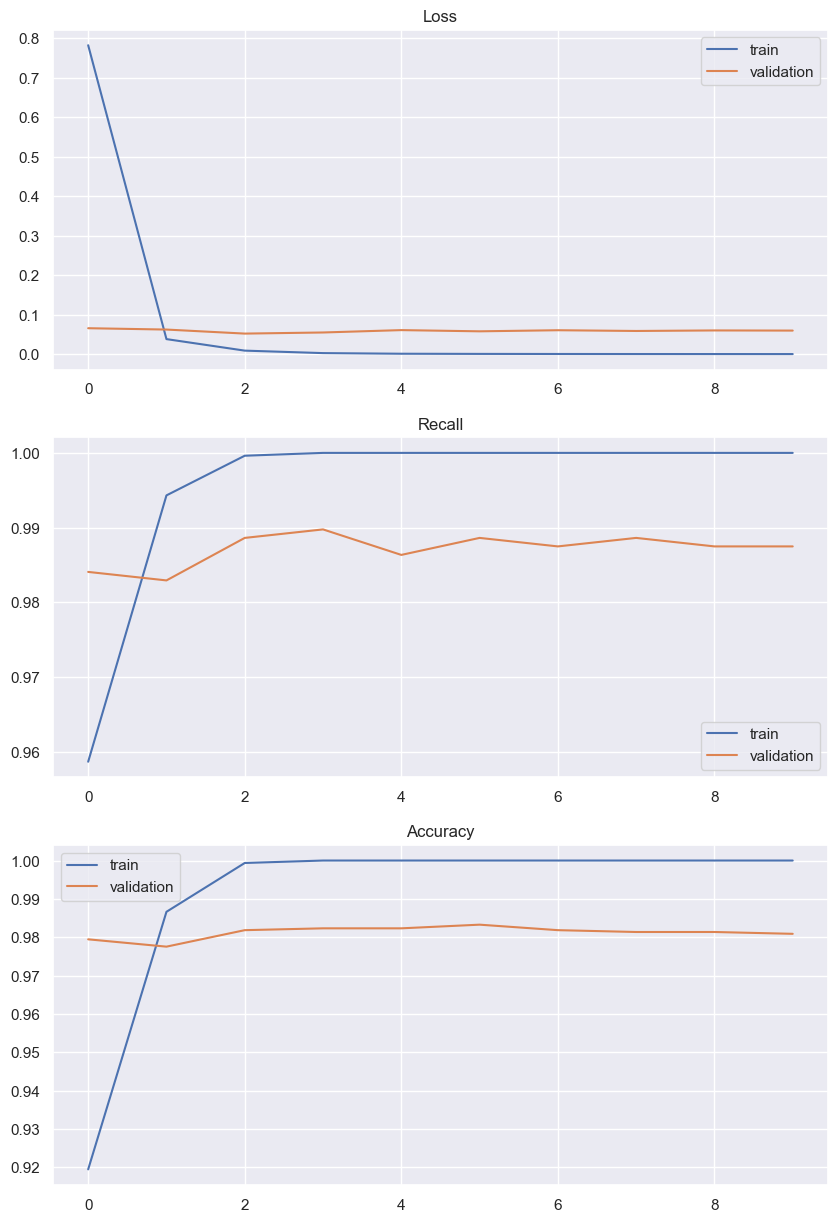

In [7]:
plot_loss_and_accuracy(simple_results)

## Additional Convolutional Layer Model

Our second iteration of the model included one additional pooling layer which is a form of downsampling that helps reduce the spatial dimensions of the input data. It can be beneficial in reducing the computational complexity of the network and controlling overfitting. We also added an additional convolutional network to pick up on more patterns in the images.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32,
                       kernel_size=(3, 3),
                       activation='relu',
                       input_shape=(300, 300, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam',
               loss='BinaryCrossentropy',
                metrics=['Recall', 'BinaryAccuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001,
                           verbose=1, patience=3,
                           mode='min')

results = model.fit(train_set, epochs=10, validation_data=val_set,
                    callbacks=[early_stop])

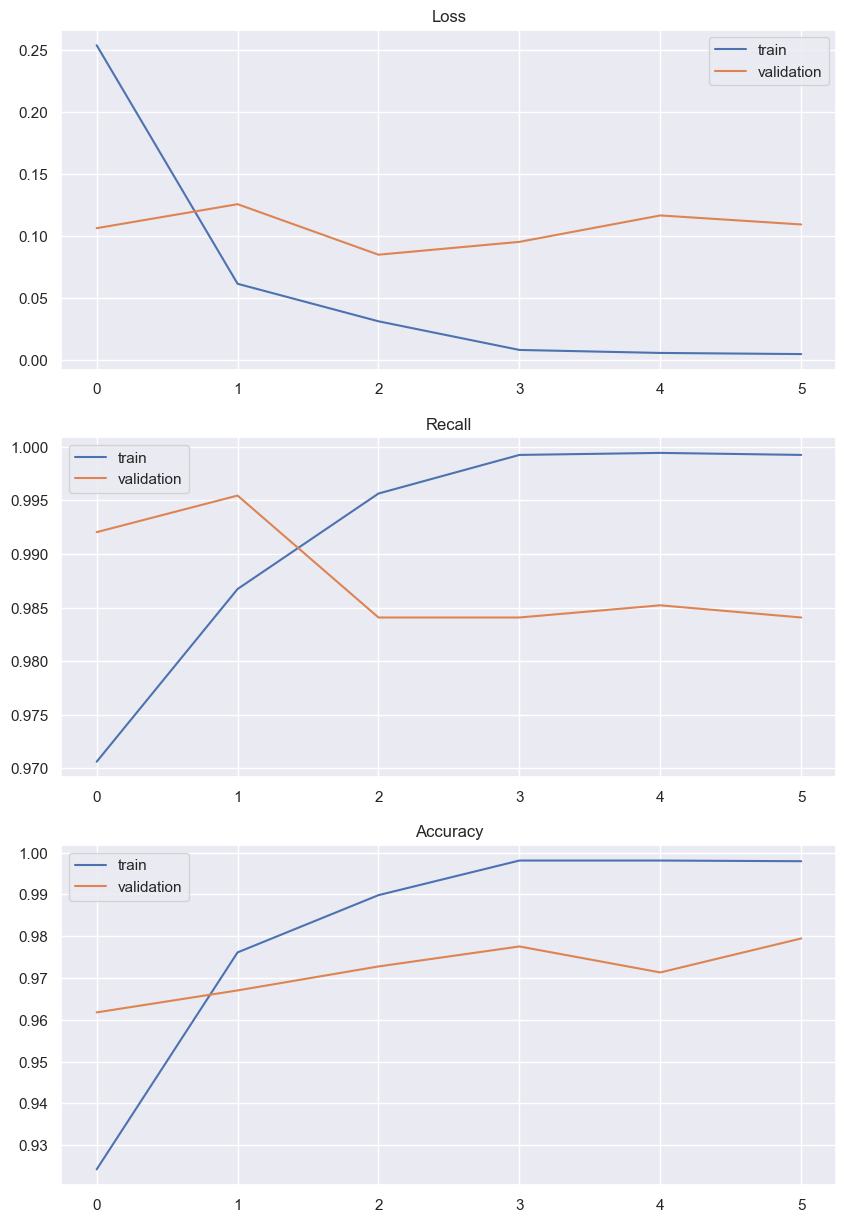

In [11]:
plot_loss_and_accuracy(results)

## Regularized Model

In our third iteration of our model we added two convolutional layers from the baseline and regularized both with an L2 of 0.05. This helps with preventing overfitting and improving the generalization of a model. We also added an early stop as we were seeing that after a certain number of epochs our scores were not improving. Training beyond this threshold would only result in a more overfit model.

In [19]:
reg_model = models.Sequential()
reg_model.add(layers.Conv2D(filters=32,
                    kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(64, 64, 1)))
reg_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
reg_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.05)))
reg_model.add(layers.MaxPooling2D((2, 2)))
reg_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.05)))
reg_model.add(layers.Flatten())
reg_model.add(layers.Dense(64, activation='relu'))
reg_model.add(layers.Dense(1, activation='sigmoid'))

reg_model.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=['Recall', 'BinaryAccuracy'])

early_stop = EarlyStopping(monitor='val_binary_accuracy', min_delta=0.001,
                           verbose=1, patience=4, restore_best_weights=True,
                           mode='auto')

reg_results = reg_model.fit(train_set, epochs=10, validation_data=val_set, callbacks=early_stop)

Epoch 1/50


2023-09-15 11:29:44.858905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - ETA: 0s - loss: 1.4638 - recall: 0.9677 - binary_accuracy: 0.8550

2023-09-15 11:29:58.650527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - 18s 147ms/step - loss: 1.4638 - recall: 0.9677 - binary_accuracy: 0.8550 - val_loss: 0.3516 - val_recall: 0.9010 - val_binary_accuracy: 0.9195
Epoch 2/50
123/123 [==============================] - 18s 145ms/step - loss: 0.2930 - recall: 0.9543 - binary_accuracy: 0.9186 - val_loss: 0.2443 - val_recall: 0.9897 - val_binary_accuracy: 0.9264
Epoch 3/50
123/123 [==============================] - 18s 145ms/step - loss: 0.2402 - recall: 0.9595 - binary_accuracy: 0.9283 - val_loss: 0.1848 - val_recall: 0.9639 - val_binary_accuracy: 0.9601
Epoch 4/50
123/123 [==============================] - 18s 143ms/step - loss: 0.1978 - recall: 0.9636 - binary_accuracy: 0.9410 - val_loss: 0.1575 - val_recall: 0.9649 - val_binary_accuracy: 0.9617
Epoch 5/50
123/123 [==============================] - 18s 143ms/step - loss: 0.1837 - recall: 0.9670 - binary_accuracy: 0.9441 - val_loss: 0.1755 - val_recall: 0.9660 - val_binary_accuracy: 0.9617
Epoch 6/50
123/123 [======

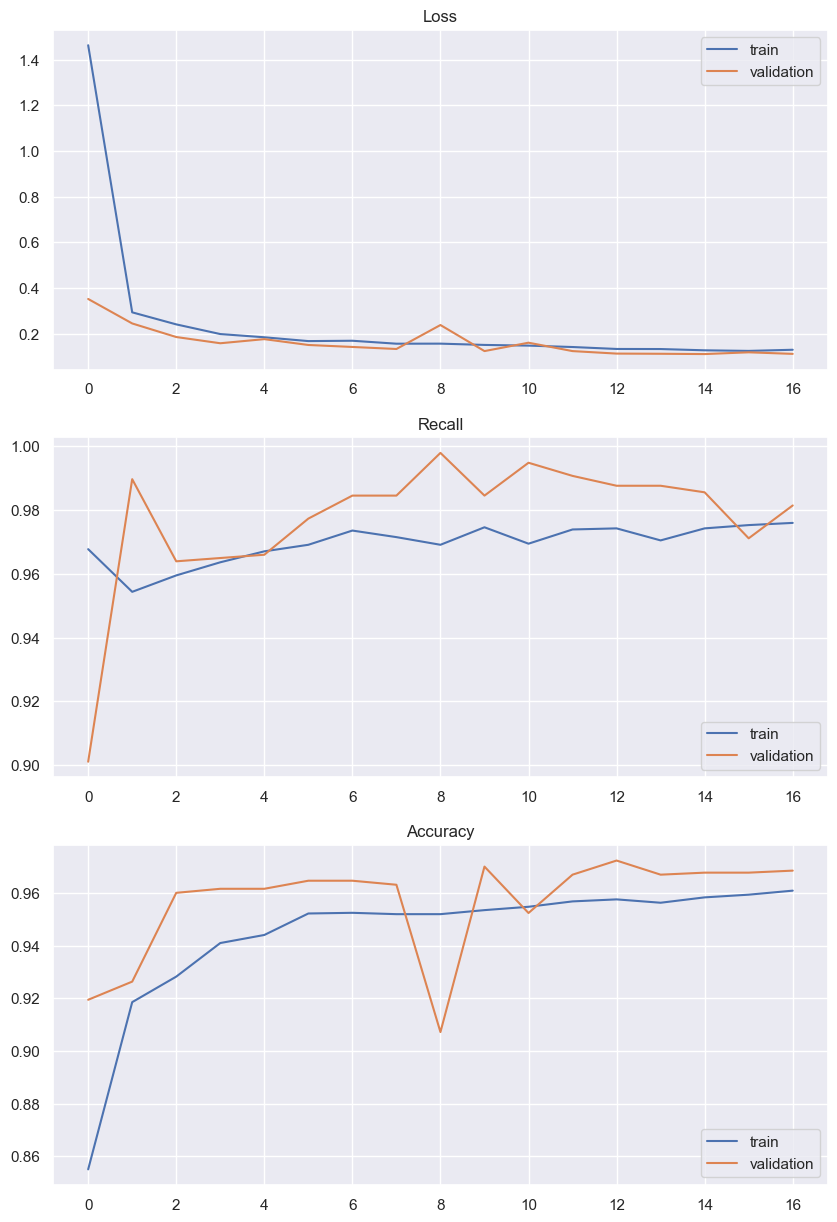

In [20]:
plot_loss_and_accuracy(reg_results)

## Complex Model

Although regularization helped our model we decided to remove the L2 regularization. We received a score of val_recall: 0.9938 - val_binary_accuracy: 0.9555. Although our val_binary_accuracy did not perform as well compared to the baseline, we see that our val_recall score is near perfect, rendering the presence of false negatives to near zero. 

In [16]:
complex_model = models.Sequential()
complex_model.add(layers.Conv2D(filters=32,
                  kernel_size=(3, 3),
                  activation='relu',
                  input_shape=(300, 300, 1)))
complex_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
complex_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
complex_model.add(layers.MaxPooling2D((2, 2)))
complex_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
complex_model.add(layers.Flatten())
complex_model.add(layers.Dense(64, activation='relu'))
complex_model.add(layers.Dense(1, activation='sigmoid'))

complex_model.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=['Recall', 'BinaryAccuracy'])

early_stop = EarlyStopping(monitor='val_binary_accuracy', min_delta=0.001,
                           verbose=1, patience=4, restore_best_weights=True,
                           mode='auto')

complex_results = complex_model.fit(train_set, epochs=10, validation_data=val_set, callbacks=early_stop)

Epoch 1/50


2023-09-15 11:21:16.031968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - ETA: 0s - loss: 0.2649 - recall: 0.9588 - binary_accuracy: 0.8857

2023-09-15 11:21:29.913754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - 18s 140ms/step - loss: 0.2649 - recall: 0.9588 - binary_accuracy: 0.8857 - val_loss: 0.1188 - val_recall: 0.9526 - val_binary_accuracy: 0.9571
Epoch 2/50
123/123 [==============================] - 17s 136ms/step - loss: 0.1165 - recall: 0.9725 - binary_accuracy: 0.9553 - val_loss: 0.0915 - val_recall: 0.9887 - val_binary_accuracy: 0.9678
Epoch 3/50
123/123 [==============================] - 17s 139ms/step - loss: 0.1003 - recall: 0.9756 - binary_accuracy: 0.9625 - val_loss: 0.0711 - val_recall: 0.9825 - val_binary_accuracy: 0.9762
Epoch 4/50
123/123 [==============================] - 17s 138ms/step - loss: 0.0804 - recall: 0.9787 - binary_accuracy: 0.9668 - val_loss: 0.0949 - val_recall: 0.9907 - val_binary_accuracy: 0.9670
Epoch 5/50
123/123 [==============================] - 17s 137ms/step - loss: 0.0696 - recall: 0.9818 - binary_accuracy: 0.9722 - val_loss: 0.0918 - val_recall: 0.9598 - val_binary_accuracy: 0.9647
Epoch 6/50
123/123 [======

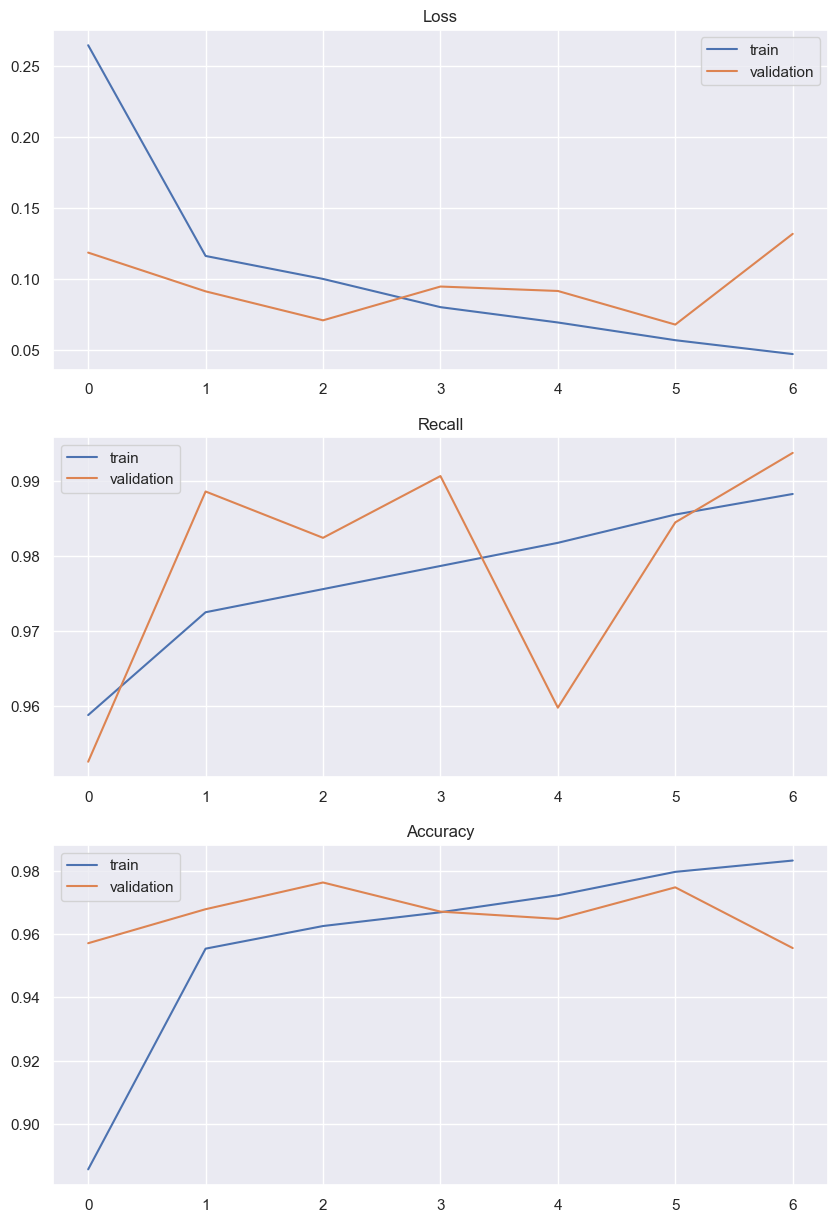

In [21]:
plot_loss_and_accuracy(complex_results)

## Simple Model Regularized and Pooled (Best)

For our best model, we decided to shed some of the complexity of our last two models and simply one l2 regularization and one pooling layer to our baseline model. We see that this model overall returns the best average scores for recall and accuracy and is faster to train. Our Final cross validated scores are val_recall: 0.9866 - val_binary_accuracy: 0.9801. And on testing data we received recall: 0.9949 - binary_accuracy: 0.8349.

In [34]:
best_model = models.Sequential()
best_model.add(layers.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(300, 300, 1), kernel_regularizer=tf.keras.regularizers.L2(l2=0.05)))
best_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(1, activation='sigmoid'))

best_model.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=['Recall', 'BinaryAccuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001,
                           verbose=1, patience=3,
                           mode='min')
                 
best_results = best_model.fit(train_set, epochs=10, validation_data=val_set, callbacks=[early_stop])

Epoch 1/10


2023-09-15 12:02:48.633404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - ETA: 0s - loss: 1.1752 - recall: 0.9107 - binary_accuracy: 0.8655

2023-09-15 12:03:58.185353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - 75s 605ms/step - loss: 1.1752 - recall: 0.9107 - binary_accuracy: 0.8655 - val_loss: 0.2027 - val_recall: 0.9567 - val_binary_accuracy: 0.9555
Epoch 2/10
123/123 [==============================] - 74s 600ms/step - loss: 0.1608 - recall: 0.9832 - binary_accuracy: 0.9727 - val_loss: 0.1477 - val_recall: 0.9897 - val_binary_accuracy: 0.9747
Epoch 3/10
123/123 [==============================] - 73s 595ms/step - loss: 0.1309 - recall: 0.9880 - binary_accuracy: 0.9834 - val_loss: 0.1345 - val_recall: 0.9804 - val_binary_accuracy: 0.9801
Epoch 4/10
123/123 [==============================] - 76s 613ms/step - loss: 0.1014 - recall: 0.9969 - binary_accuracy: 0.9944 - val_loss: 0.1307 - val_recall: 0.9887 - val_binary_accuracy: 0.9785
Epoch 5/10
123/123 [==============================] - 77s 626ms/step - loss: 0.0925 - recall: 0.9962 - binary_accuracy: 0.9952 - val_loss: 0.1289 - val_recall: 0.9845 - val_binary_accuracy: 0.9778
Epoch 6/10
123/123 [======

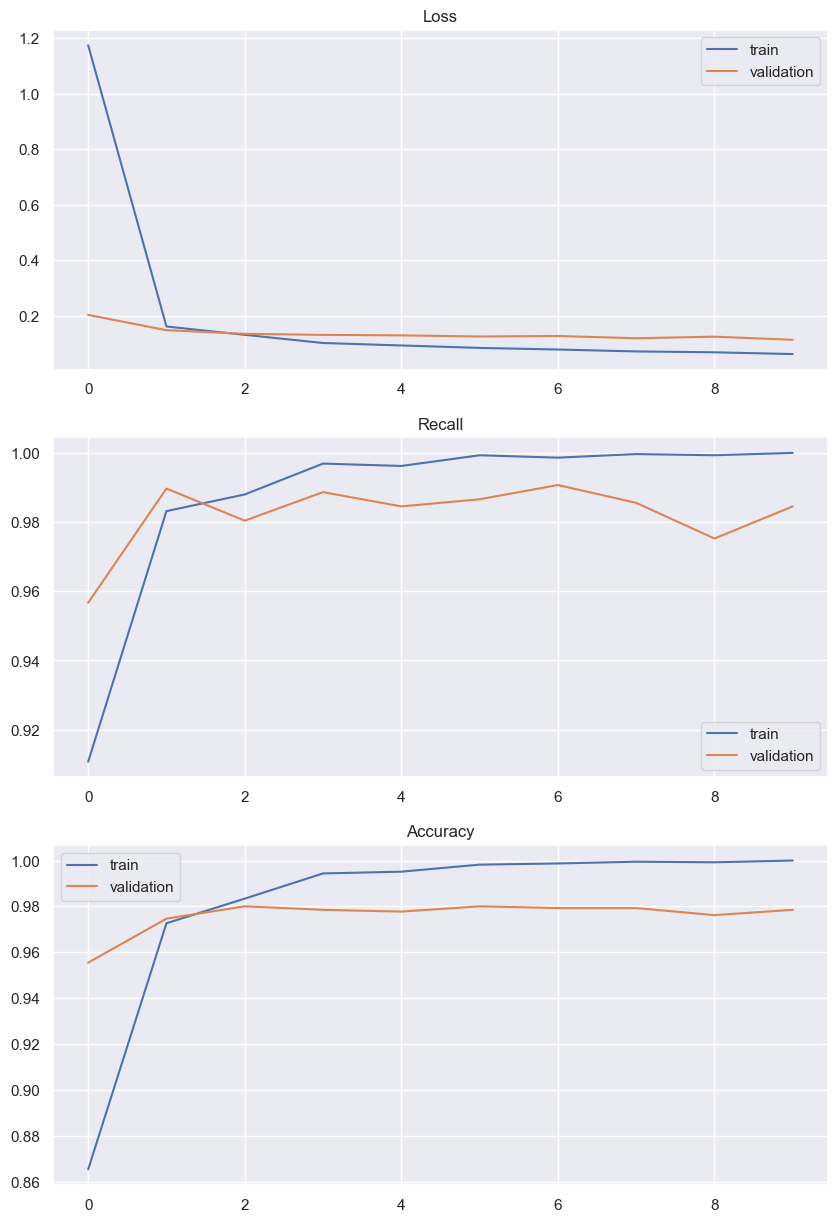

In [35]:
plot_loss_and_accuracy(best_results)

In [37]:
best_model.evaluate(test_set)

20/20 [==============================] - 3s 130ms/step - loss: 0.8012 - recall: 0.9949 - binary_accuracy: 0.8349


[0.801237940788269, 0.9948718547821045, 0.8349359035491943]

## Confusion Matrix

Here is a plot of our confusion matrix of our best model for our hypothesis test. There is also a bar graph outlining our different outcomes: false positive, false negative, true positive, true negative. 

1/1 [==============================] - 0s 48ms/step


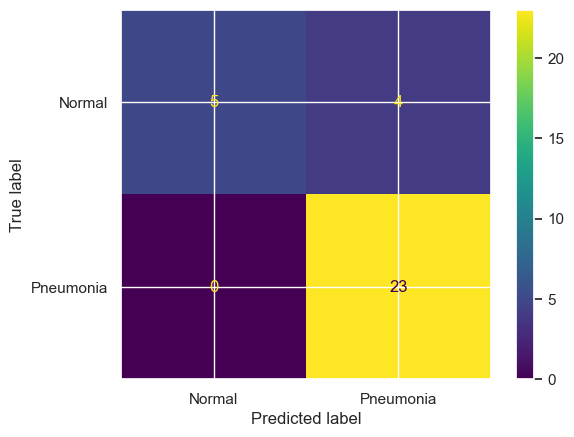

In [43]:
predictions = simple_model.predict(test_images)  # probabilities
rounded_predictions = np.round(predictions)
cm = confusion_matrix(test_labels, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Normal', 'Pneumonia'], )
disp.plot()

For accessibility

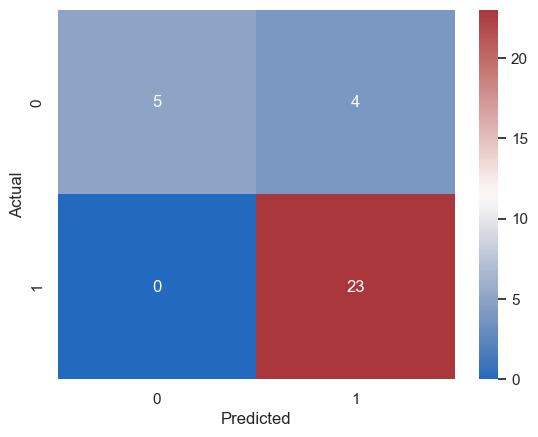

In [80]:
sns.heatmap(cm, annot=True, cmap='vlag')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

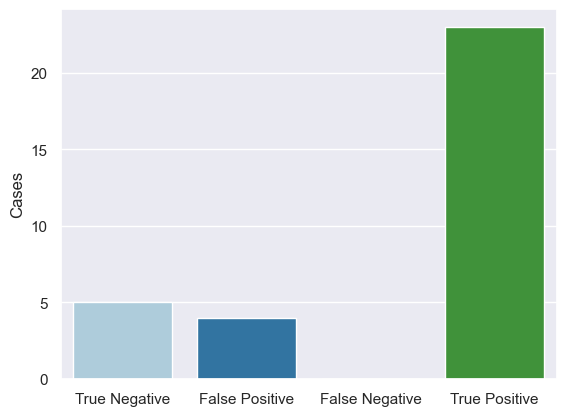

In [72]:
cm_data = pd.DataFrame(data=(cm.flatten()).T, index=['True Negative', 'False Positive', 'False Negative', 'True Positive'])
ax = sns.barplot( data=cm_data.T)

# Customizing the plot
sns.set_palette("Paired")  # Changing the color palette
plt.ylabel('Cases')

# Display the plot
plt.show();

## Evaluation

We determined our best model based on our validation set. We saw that our model was neither under nor overfit because its scores were similar on both the training and validation data sets.

After selecting our best model, we evaluated it with our holdout testing set. The model scored XX for recall and XX for accuracy.

The lower accuracy score was unexpected. It is not a bad score, but it is not in line with the scores we saw for our training and validation. Were it not for the validation set, we would assume our model is overfit to the training data. The validation data, however, supports our interpretation that our model is well-tuned. It is possible that the images just didn't break into sets in a particularly representative way. Short of procuring our own set of comparable x-rays, there's not much we can do to address this issue.

Though the lower accuracy score raised an eyebrow, we are still confident that the model is strong and generalizable. Even as accuracy dropped, it did not drop precipitously and the recall score remained incredibly high. The model might have more false positives, but as long as false negatives are still kept to the absolute minimum, this model is still effectively reducing the workload for healthcare professionals without elevating the risks for patients.

Our model misses almost no true pneumonia cases (and even a human expert likely errs occasionally) and it significantly reduces the number of x-rays that have to be analyzed. In an overtaxed healthcare setting, that's all upside.

## Conclusions

We would recommend that clinics or hospitals that see a lot of juvenile patients with suspected pneumonia send their chest x-rays through our model. Medical experts can review the x-rays flagged as positive. This process will free up human resources and will allow providers to treat their patients more quickly and effectively. For cases classified as negative, this allows the care team to pursue other explanations for the patient's illness, and in positive cases also IDed as positive by the experts, the care team can quickly begin appropriate treatments.

This model only improves one step in the treatment of pneumonia. If there are backlogs in ordering a chest x-ray or actually performing the x-ray, then the benefits of our model will be limited. Healthcare providers should evaluate all steps in the diagnosis process to see if other bottlenecks can be mitigated.

Given more time, we would consider pooling the training and testing sets together and doing a random split instead of using the provided train/test sets. Training our model on our own randomly split sets would allow us to see if the disparity in validation and testing accuracy scores that we saw was truly an artifact of a funky data split. As other data scientists have also mentioned issues with the accuracy scores on the testing set, it might also be valuable to have a medical expert review those images to ensure they are properly labelled. We don't have the skills to do that, and it might be time- or cost-prohibitive for our potential clients. Even without these further investigations, we still feel quite confident in the value our model could provide in a medical setting. 